<a href="https://colab.research.google.com/github/emilia-uncc/IntroML/blob/main/Assignment6/Homework6_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable


#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
file_path = '/content/drive/My Drive/DataSets/Housing.csv'
housing = pd.DataFrame(pd.read_csv(file_path))
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [3]:
housing.isnull().sum()*100/housing.shape[0]

price               0.0
area                0.0
bedrooms            0.0
bathrooms           0.0
stories             0.0
mainroad            0.0
guestroom           0.0
basement            0.0
hotwaterheating     0.0
airconditioning     0.0
parking             0.0
prefarea            0.0
furnishingstatus    0.0
dtype: float64

In [4]:
varlist =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

# Defining the map function
def binary_map(x):
    return x.map({'yes': 1, 'no': 0})

# Applying the function to the housing list
housing[varlist] = housing[varlist].apply(binary_map)
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


In [5]:
selected_columns_indices = [1, 2, 3, 4,5, 6, 7, 8, 9, 10,11]
print(selected_columns_indices)
X = housing.iloc[:, selected_columns_indices].values
#M = 1, E = 0
Y = housing.iloc[:, 0].values
np.random.seed(0)
#df_train = training set, #df_test = testset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 0)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [6]:
#scale dataset, inputs and outputs
#scaler = StandardScaler()
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Fit the scaler on the data
scaler.fit(Y_train.reshape(-1, 1))  # Reshape the 1D array to 2D (n_samples, n_features)
# Transform the data
Y_train = scaler.transform(Y_train.reshape(-1, 1))

scaler.fit(Y_test.reshape(-1, 1))
Y_test = scaler.transform(Y_test.reshape(-1, 1))

print(X_train[0], X_test[0], Y_train[0], Y_test[0])

[0.12419939 0.2        0.         0.         1.         0.
 0.         0.         0.         0.         0.        ] [0.15065441 0.4        0.         0.33333333 1.         0.
 0.         0.         0.         0.33333333 0.        ] [0.] [0.27]


In [7]:
#arrays into tensors
X_train_tensor =torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

In [8]:
def training_loop(n_epochs,optimizer,model, criterion, X_train, Y_train, X_test, Y_test):
  test_losses = []
  train_losses = []

  for epoch in range(1, n_epochs+1):
      # Converting inputs and labels to Variable
      inputs = Variable(X_train)
      labels = Variable(Y_train)
      inputs_val = Variable(X_test)
      labels_val = Variable(Y_test)

      # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
      optimizer.zero_grad()
      #optimizer_sgd.zero_grad()

      # get output from the model, given the inputs
      outputs = model(inputs)
      # get loss for the predicted output
      loss = criterion(outputs, labels)

      # Forward pass and loss calculation for the test set
      with torch.no_grad():
          val_pred = model(inputs_val)
          test_loss = criterion(val_pred, labels_val)

      #print(loss)
      # get gradients w.r.t to parameters
      loss.backward()

      # update parameters
      optimizer.step()
      #optimizer_sgd.step()

      if epoch % 500 == 0:
              print(f"Epoch: {epoch}, Loss: {loss.item()}, val_loss: {test_loss.item()}")

      train_losses.append(loss.item())
      test_losses.append(test_loss.item())

  return train_losses, test_losses

In [9]:
#set input and output dimensions
inputDim = 11
outputDim = 1
#set learning rate and epochs
learningRate = 0.01
epochs = 5000

#Homework 6 1a)

seq_model = nn.Sequential(nn.Linear(inputDim, 32), nn.Tanh(), nn.Linear(32,1))

criterion = torch.nn.MSELoss() #set lossfuntion from neural network library
optimizer_adam = torch.optim.Adam(seq_model.parameters(), lr=learningRate) #set optimizer Adam
optimizer_sgd = torch.optim.SGD(seq_model.parameters(), lr=learningRate) #set optimizer SGD

train_losses, val_losses = training_loop(epochs,optimizer_sgd,seq_model, criterion, X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor)




Epoch: 500, Loss: 0.012794879265129566, val_loss: 0.01423943042755127
Epoch: 1000, Loss: 0.011207429692149162, val_loss: 0.01240356732159853
Epoch: 1500, Loss: 0.01051485724747181, val_loss: 0.011494751088321209
Epoch: 2000, Loss: 0.010116844438016415, val_loss: 0.01091204583644867
Epoch: 2500, Loss: 0.009854787029325962, val_loss: 0.010508262552320957
Epoch: 3000, Loss: 0.009668577462434769, val_loss: 0.010218895971775055
Epoch: 3500, Loss: 0.0095301428809762, val_loss: 0.010006988421082497
Epoch: 4000, Loss: 0.0094242999330163, val_loss: 0.009849164634943008
Epoch: 4500, Loss: 0.009341869503259659, val_loss: 0.009729888290166855
Epoch: 5000, Loss: 0.00927677284926176, val_loss: 0.009638522751629353


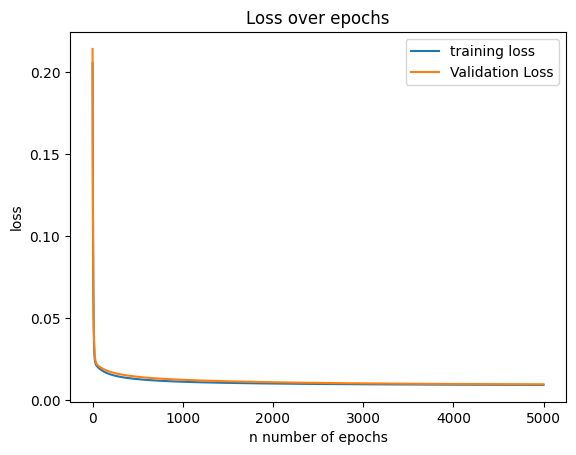

In [10]:
# 4. Plot the training and validation loss after each iteration
plt.plot(train_losses, label="training loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("n number of epochs")
plt.ylabel("loss")
plt.legend()
plt.title("Loss over epochs")
plt.show()

In [37]:
#Homework 6 1b)
learningRate = 0.01
epochs = 10000


inputDim = 11

hidden_layers = [32, 64, 16]  # Define the number of neurons in each hidden layer

layers = [nn.Linear(inputDim, hidden_layers[0]), nn.Tanh()]

# Add hidden layers and activation functions
for i in range(len(hidden_layers) - 1):
    layers.extend([nn.Linear(hidden_layers[i], hidden_layers[i + 1]), nn.Tanh()])

# Output layer
layers.append(nn.Linear(hidden_layers[-1], 1))  # Assuming output size is 1

seq_model_2 = nn.Sequential(*layers)
optimizer_sgd_2 = torch.optim.SGD(seq_model_2.parameters(), lr=learningRate) #set optimizer SGD
optimizer_adam_2 = torch.optim.Adam(seq_model_2.parameters(), lr=learningRate) #set optimizer Adam

#seq_model = nn.Sequential(nn.Linear(inputDim, 32), nn.Tanh(), nn.Linear(32,64), nn.Tanh(), nn.Linear(64, 16), nn.Tanh(), nn.Linear(16,1))
train_losses_2, val_losses_2 = training_loop(epochs,optimizer_sgd_2,seq_model_2, criterion, X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor)


Epoch: 500, Loss: 0.015624216757714748, val_loss: 0.016774408519268036
Epoch: 1000, Loss: 0.013392657041549683, val_loss: 0.014929317869246006
Epoch: 1500, Loss: 0.0122299175709486, val_loss: 0.01381026953458786
Epoch: 2000, Loss: 0.011539310216903687, val_loss: 0.01297799963504076
Epoch: 2500, Loss: 0.011085698381066322, val_loss: 0.012320300564169884
Epoch: 3000, Loss: 0.010763050056993961, val_loss: 0.011793550103902817
Epoch: 3500, Loss: 0.010518168099224567, val_loss: 0.011368926614522934
Epoch: 4000, Loss: 0.010321926325559616, val_loss: 0.011023296043276787
Epoch: 4500, Loss: 0.010157784447073936, val_loss: 0.01073846872895956
Epoch: 5000, Loss: 0.010016266256570816, val_loss: 0.010500751435756683
Epoch: 5500, Loss: 0.009891944006085396, val_loss: 0.01030017901211977
Epoch: 6000, Loss: 0.009781643748283386, val_loss: 0.010129577480256557
Epoch: 6500, Loss: 0.009683407843112946, val_loss: 0.009983708150684834
Epoch: 7000, Loss: 0.00959593616425991, val_loss: 0.009858688339591026


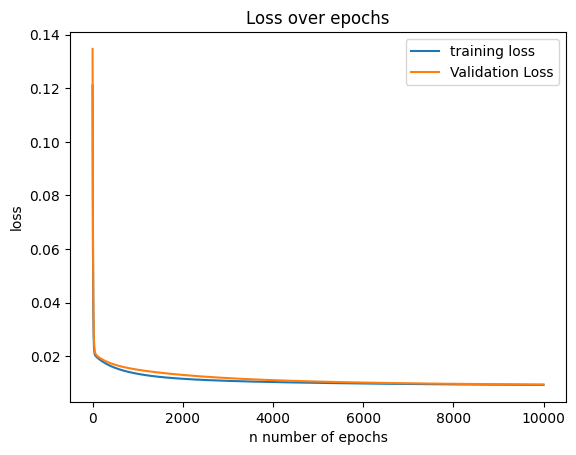

In [38]:
# 4. Plot the training and validation loss after each iteration
plt.plot(train_losses_2, label="training loss")
plt.plot(val_losses_2, label="Validation Loss")
plt.xlabel("n number of epochs")
plt.ylabel("loss")
plt.legend()
plt.title("Loss over epochs")
plt.show()